In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
model = load_model('model1_waterflow_mse_32.hdf5')

In [3]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [4]:
train_cols = ["Precipitation","Temperature","Outflow"]

In [5]:
new_df = df.filter(train_cols, axis=1)

In [6]:
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

In [7]:
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

In [8]:
lag_df

,Precipitation,Temperature,Outflow,Outflow(t+1)
0,0.0,102.992,5.0,5.0
1,0.0,97.790,5.0,5.0
2,0.0,92.588,5.0,5.0
3,0.0,87.404,5.0,5.0
4,0.0,85.172,5.0,5.0
...,...,...,...,...
185538,0.0,52.880,29.0,30.0
185539,0.0,54.284,30.0,29.0
185540,0.0,55.670,29.0,29.0
185541,0.0,57.074,29.0,31.0


In [9]:
#label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]
label_cols = ["Outflow(t+1)"]

In [10]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [11]:
#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [12]:
x_train.shape, y_test.shape

((148434, 3), (37109, 1))

In [13]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)

In [14]:
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [15]:
y_train_actual = y_train
y_test_actual = y_test

In [16]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



length of time-series i/o (148416, 18, 3) (148416,)



length of time-series i/o (37091, 18, 3) (37091,)


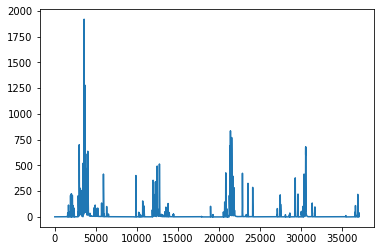

In [17]:
plt.figure()
plt.plot(y_test)
plt.show()

In [18]:
def prepare_data(x_values, y_values, threshold = 250, timesteps = 18):
    values_above_thres = []
    labels_above_theres = []
    threshold = 250
    timesteps = 18

    for i in range(timesteps, x_values.shape[0]):
        if (y_values[i] > threshold):
            values_above_thres.append(x_values[i-timesteps:i])
            labels_above_theres.append(y_values[i])
    
    X_values = np.array(values_above_thres)
    Y_values = np.array(labels_above_theres)
    nsamples, na, nb = X_values.shape
    x_values_for_normalization = X_values.reshape((nsamples,na*nb)) # since normalization requires 2d array
    #x_train_for_normalization.shape       
    

In [19]:
# data preparation for tuning with extreme values
values_above_thres = []
labels_above_theres = []
threshold = 250
timesteps = 18

for i in range(timesteps, x_train.shape[0]):
    if (y_train[i] > threshold):
        values_above_thres.append(x_train[i-timesteps:i])
        labels_above_theres.append(y_train[i])
        
X_train = np.array(values_above_thres)
Y_train = np.array(labels_above_theres)

nsamples, na, nb = X_train.shape
x_train_for_normalization = X_train.reshape((nsamples,na*nb)) # since normalization requires 2d array
x_train_for_normalization.shape

#Normalizing training data
X_Train1 = xtrain_min_max_scaler.fit_transform(x_train_for_normalization)
Y_Train1 = ytrain_min_max_scaler.fit_transform(Y_train)

X_Train1 = X_Train1.reshape((nsamples, na, nb))

In [20]:
test_values_above_thres = []
test_labels_above_theres = []

for i in range(timesteps, x_test.shape[0]):
    if (y_test[i] > threshold):
        test_values_above_thres.append(x_test[i-timesteps:i])
        test_labels_above_theres.append(y_test[i]) 
        
X_test_abv_thres = np.array(test_values_above_thres)
Y_test_abv_thres = np.array(test_labels_above_theres)

tsamples, ta, tb = X_test_abv_thres.shape
x_test_for_normalization = X_test_abv_thres.reshape((tsamples,ta*tb)) # since normalization requires 2d array
x_test_for_normalization.shape

X_Test_abv_thres = xtest_min_max_scaler.fit_transform(x_test_for_normalization)
Y_Test_abv_thres = ytest_min_max_scaler.fit_transform(Y_test_abv_thres)

X_Test_abv_thres = X_Test_abv_thres.reshape((tsamples, ta, tb))

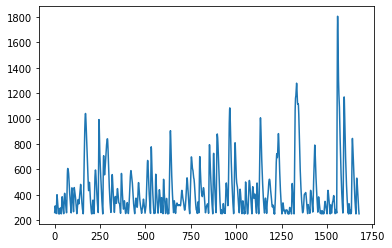

In [21]:
plt.figure()
plt.plot(labels_above_theres)
plt.show()

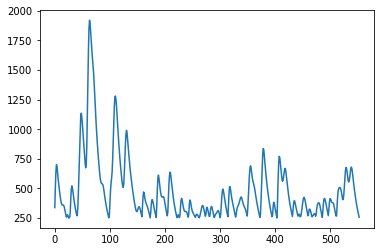

In [22]:
plt.figure()
plt.plot(test_labels_above_theres)
plt.show()

In [23]:
X_test_abv_thres.shape, Y_test_abv_thres.shape

((553, 18, 3), (553, 1))

In [24]:
X_train.shape, Y_train.shape

((1678, 18, 3), (1678, 1))

In [25]:
X_Train1.shape, Y_Train1.shape

((1678, 18, 3), (1678, 1))

In [26]:
X_Train.shape,Y_Train.shape

((148416, 18, 3), (148416,))

In [27]:
X_Train.shape

(148416, 18, 3)

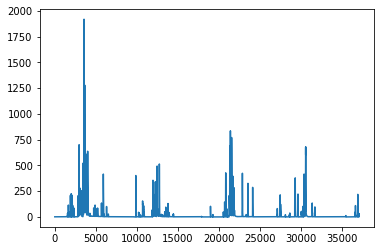

In [28]:
plt.figure()
plt.plot(Y_test_actual)
plt.show()

In [29]:
val_error_accumulation = []
train_error_accumulation = []

In [30]:
history = model.fit(X_Train1, Y_Train1, epochs=2,
                   validation_data=(X_Test, Y_Test))

Epoch 1/2
53/53 [==============================] - 4s 76ms/step - loss: 0.0018 - val_loss: 2.0591e-04
Epoch 2/2
53/53 [==============================] - 4s 66ms/step - loss: 6.0593e-04 - val_loss: 4.0133e-04


In [31]:
for i in history.history['val_loss']:
    val_error_accumulation.append(i)

for i in history.history['loss']:
    train_error_accumulation.append(i)

In [32]:
model.save("modelwaterflow_alternate_data.hdf5")

In [33]:
model1 = load_model('modelwaterflow_alternate_data.hdf5')

In [34]:
history = model1.fit(X_Train, Y_Train, epochs=2,
                   validation_data=(X_Test, Y_Test))

Epoch 1/2
4638/4638 [==============================] - 49s 11ms/step - loss: 1.3191e-05 - val_loss: 4.6692e-06
Epoch 2/2
4638/4638 [==============================] - 47s 10ms/step - loss: 1.1954e-05 - val_loss: 5.4655e-06


In [35]:
for i in history.history['val_loss']:
    val_error_accumulation.append(i)

for i in history.history['loss']:
    train_error_accumulation.append(i)

In [36]:
model1.save("modelwaterflow_alternate_data1.hdf5")

In [37]:
model2 = load_model('modelwaterflow_alternate_data1.hdf5')

In [38]:
history = model2.fit(X_Train1, Y_Train1, epochs=2,
                   validation_data=(X_Test, Y_Test))

Epoch 1/2
53/53 [==============================] - 5s 90ms/step - loss: 0.0021 - val_loss: 2.2455e-04
Epoch 2/2
53/53 [==============================] - 5s 87ms/step - loss: 6.8538e-04 - val_loss: 3.6698e-04


In [39]:
for i in history.history['val_loss']:
    val_error_accumulation.append(i)

for i in history.history['loss']:
    train_error_accumulation.append(i)

In [40]:
model2.save("modelwaterflow_alternate_data2.hdf5")

In [41]:
model3 = load_model('modelwaterflow_alternate_data2.hdf5')

In [42]:
history = model3.fit(X_Train, Y_Train, epochs=2,
                   validation_data=(X_Test, Y_Test))

Epoch 1/2
4638/4638 [==============================] - 51s 11ms/step - loss: 1.2833e-05 - val_loss: 6.4679e-06
Epoch 2/2
4638/4638 [==============================] - 49s 11ms/step - loss: 1.3010e-05 - val_loss: 7.3954e-06


In [43]:
for i in history.history['val_loss']:
    val_error_accumulation.append(i)

for i in history.history['loss']:
    train_error_accumulation.append(i)

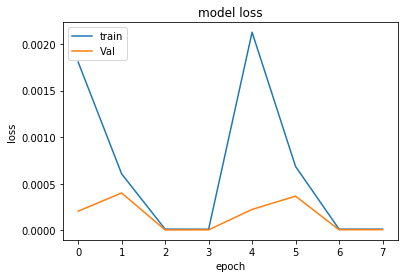

In [44]:
plt.plot(train_error_accumulation)
plt.plot(val_error_accumulation)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [46]:
train_error_accumulation, val_error_accumulation

([0.0018058016430586576,
  0.0006059305742383003,
  1.319146485911915e-05,
  1.1953755347349215e-05,
  0.002126180799677968,
  0.0006853792001493275,
  1.2832809261453804e-05,
  1.3009837857680395e-05],
 [0.00020591109932865947,
  0.0004013324505649507,
  4.669162990467157e-06,
  5.465539743454428e-06,
  0.0002245459909318015,
  0.0003669804136734456,
  6.467885668826057e-06,
  7.395384727715282e-06])

In [47]:
#model.save("model12_waterflow.hdf5")

In [48]:
predicted_y_values = model3.predict(X_Test)

In [49]:
predicted_y_values_unnor = ytest_min_max_scaler.inverse_transform(predicted_y_values)

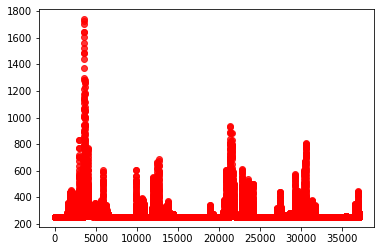

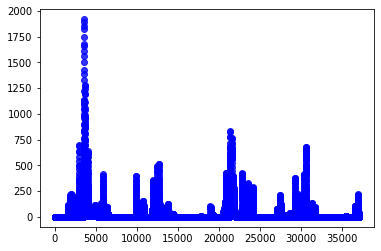

In [50]:
plt.figure()
plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
plt.show()
plt.figure()
plt.plot(Y_test_actual, 'bo', alpha=0.8)
plt.show()

In [51]:
mean_square_root = mean_squared_error(predicted_y_values_unnor, Y_test_actual)
mean_square_root

62523.81869004463

In [52]:
predicted_y_test_abv_thres = model3.predict(X_Test_abv_thres)
predicted_y_test_abv_thres_unnor = ytest_min_max_scaler.inverse_transform(predicted_y_test_abv_thres)
mean_square_root_abv_thres = mean_squared_error(predicted_y_test_abv_thres, Y_test_abv_thres)
mean_square_root_abv_thres

299547.1538291948